In [90]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from scipy.spatial.distance import mahalanobis
import scipy
import imblearn
from imblearn.over_sampling import SMOTE
from scipy import stats
import math

# READING DATA INTO NOTEBOOK

In [91]:
### reading data into notebook
train_identity = pd.read_csv(r'train_identity.csv')
test_identity = pd.read_csv(r'test_identity.csv')
test_transaction = pd.read_csv(r'test_transaction.csv')
train_transaction = pd.read_csv(r'train_transaction.csv')

trainDF = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
testDF = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

#print features
print("Features in train:\n", trainDF.columns.tolist())
print(trainDF.dtypes)
print("\nFeatures in test:\n", testDF.columns.tolist())
print(testDF.dtypes)

#fixing timestamps
trainDF['TransactionDay'] = (trainDF['TransactionDT'] // 86400).astype(int)
trainDF['TransactionDayOfWeek'] = trainDF['TransactionDay'] % 7
trainDF['TransactionWeek'] = (trainDF['TransactionDT'] // 604800).astype(int)

Features in train:
 ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V7

# Fraud vs Non-Fraud Counts

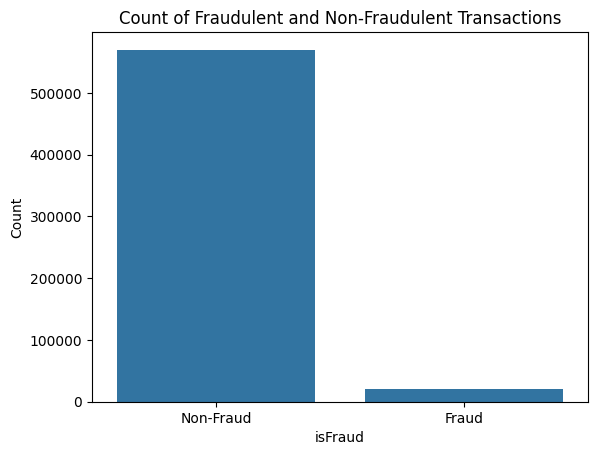

Percentage of Fraudulent Transactions: 0.03499000914417313


In [92]:
#Showing Distribution of Fraudulent vs Non-Fraudulent Transactions
fraud_counts = trainDF['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index.map({0:"Non-Fraud", 1:"Fraud"}), y=fraud_counts.values)
plt.ylabel('Count')
plt.title('Count of Fraudulent and Non-Fraudulent Transactions')
plt.show()
print("Percentage of Fraudulent Transactions:", trainDF.isFraud.mean())
#Around 4 percent is flagged fraud 

In [93]:
#Correlation between transaction amount and fraudulent classification of transactions.
correlation = trainDF['TransactionAmt'].corr(trainDF['isFraud'])
print("Correlation between transaction amount and fraud flag:", correlation)
#Violates our hypothesis of there being immense correlation between TransactionAmt and fraud. Potentially indicates 
#most fraudulent transactions contain smaller transaction amounts to attempt to have less attention towards it.

Correlation between transaction amount and fraud flag: 0.01131982533321524


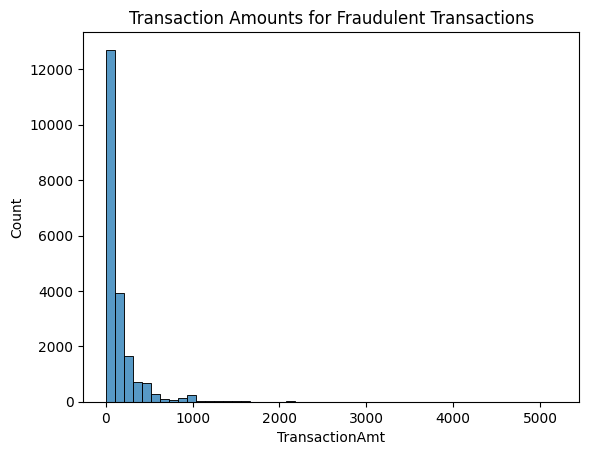

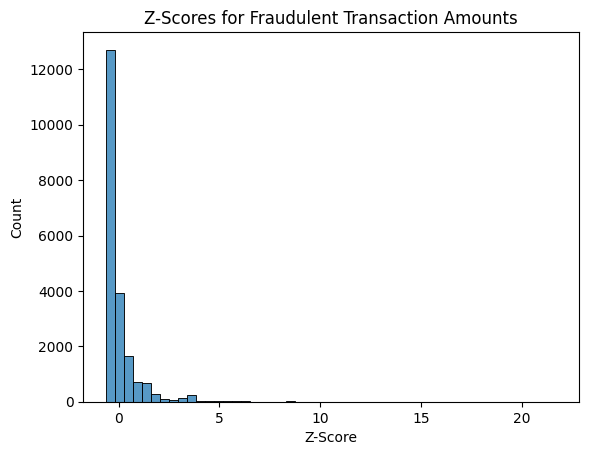

In [94]:
#Graphs of Transaction Amounts of Fraudulent Transactions + Z-scores for Fraudulent Transaction Amounts
fraudulent_transactions = trainDF[trainDF['isFraud']==1]
transaction_amounts = fraudulent_transactions['TransactionAmt']
z_scores = stats.zscore(transaction_amounts)

outliers = fraudulent_transactions[(z_scores > 3)|(z_scores < -3)]

sns.histplot(transaction_amounts, bins=50)
plt.title('Transaction Amounts for Fraudulent Transactions')
plt.show()

sns.histplot(z_scores, bins=50)
plt.title('Z-Scores for Fraudulent Transaction Amounts')
plt.xlabel('Z-Score')
plt.show()
#This further proves the hypothesis made in the last cell, most fraudulent transactions are in the lower end of transaction amounts.

In [95]:
#Ratio of Fraud Transactions in Long-Tail Transactions by Transaction Amount
long_tail_threshold = trainDF['TransactionAmt'].quantile(0.99)
long_tail_data = trainDF[trainDF['TransactionAmt'] > long_tail_threshold]
long_tail_fraud_ratio = long_tail_data['isFraud'].mean()
print(f"Fraud Ratio in Long-Tail Transactions: {long_tail_fraud_ratio}")
#Only 2% of fraudulent transactions took place in long-tail transaction amounts, thus most fraud was not in long-tail data. 

Fraud Ratio in Long-Tail Transactions: 0.024109200496365894


# Normalizing Transaction Amounts for Standard Deviation Analysis

In [96]:
mean_transaction_amt = trainDF['TransactionAmt'].mean()
std_transaction_amt = trainDF['TransactionAmt'].std()
trainDF['TransactionAmt_Zscore'] = (trainDF['TransactionAmt'] - mean_transaction_amt) / std_transaction_amt
print(trainDF[['TransactionAmt', 'TransactionAmt_Zscore']].head())
outliersZScore = trainDF[(trainDF['TransactionAmt_Zscore'] > 3) | (trainDF['TransactionAmt_Zscore'] < -3)]
print(f"Number of outliers: {outliersZScore.shape[0]}")
print(outliersZScore[['TransactionID', 'TransactionAmt', 'TransactionAmt_Zscore']])

   TransactionAmt  TransactionAmt_Zscore
0            68.5              -0.278167
1            29.0              -0.443327
2            59.0              -0.317889
3            50.0              -0.355520
4            50.0              -0.355520
Number of outliers: 10093
        TransactionID  TransactionAmt  TransactionAmt_Zscore
60            2987060         2454.00               9.696222
110           2987110         1153.95               4.260378
133           2987133         2594.95              10.285570
135           2987135         3000.00              11.979188
163           2987163          973.95               3.507752
...               ...             ...                    ...
590402        3577402         1331.00               5.000670
590405        3577405         2286.27               8.994899
590408        3577408         1615.74               6.191241
590464        3577464         1731.30               6.674427
590519        3577519         1659.95               6.376

# Distribution of Credit Card Distributors Across all Transactions

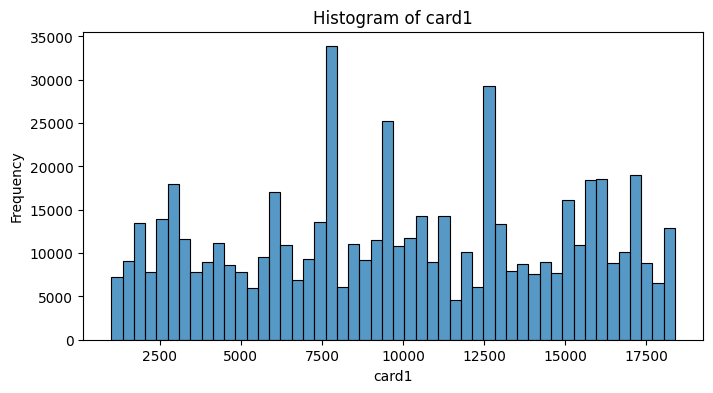

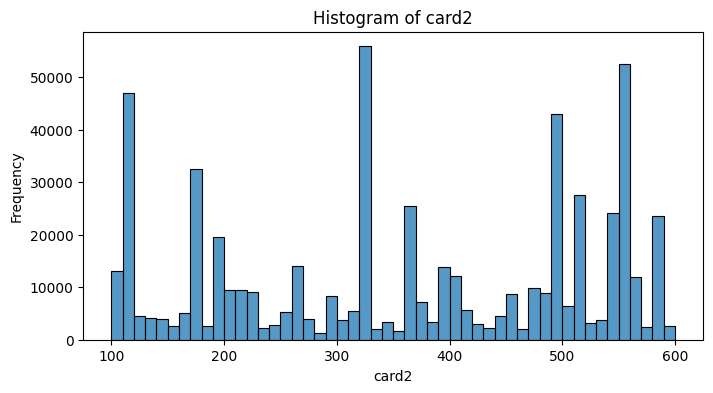

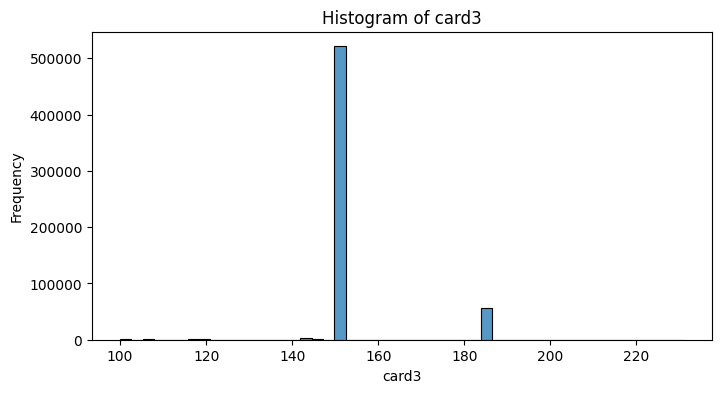

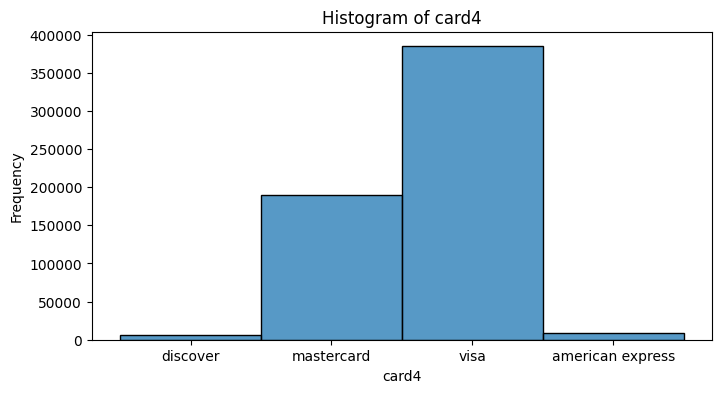

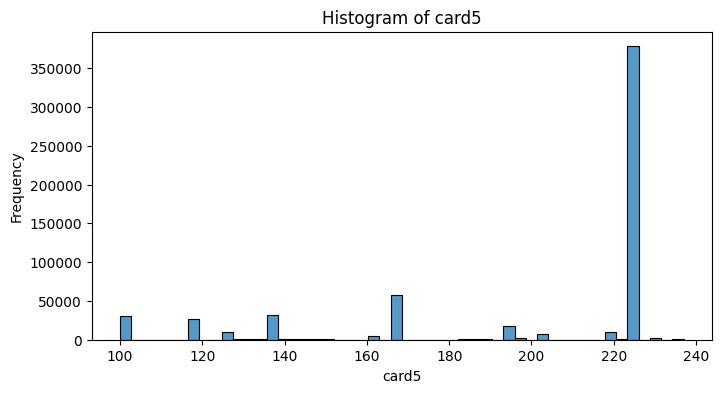

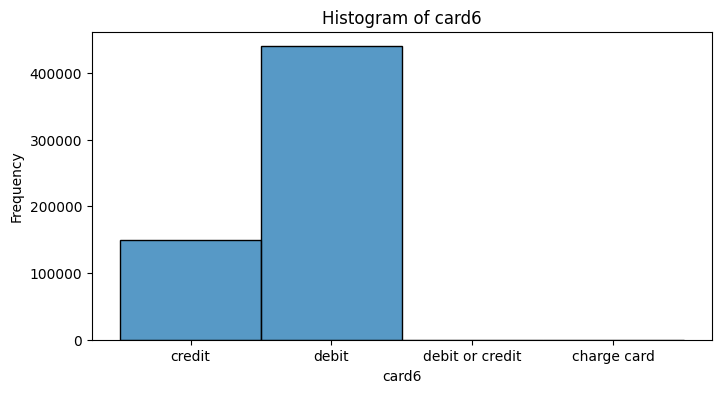

In [97]:
card_columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6'] 
#categorical variables, with all transactions having card1, card2 less than card1, card3 less than card2
#card4 is credit card distributor, #card5-country, #card6- card type.
for card in card_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(trainDF[card].dropna(), kde=False, bins=50)  # Drop NaNs before plotting
    plt.title(f'Histogram of {card}')
    plt.xlabel(f'{card}')
    plt.ylabel('Frequency')
    plt.show()
#most used digital payments companies are Visa and Mastercard, this is expected to hold for fraudulent transactions as well. 

# Distribution of Credit Card Distributors Across Fraudulent Transactions

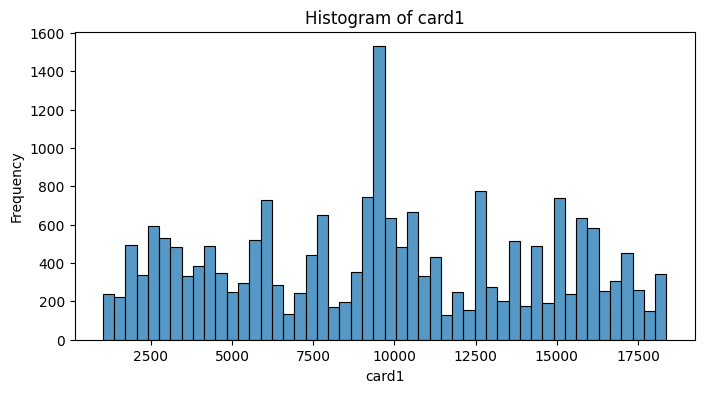

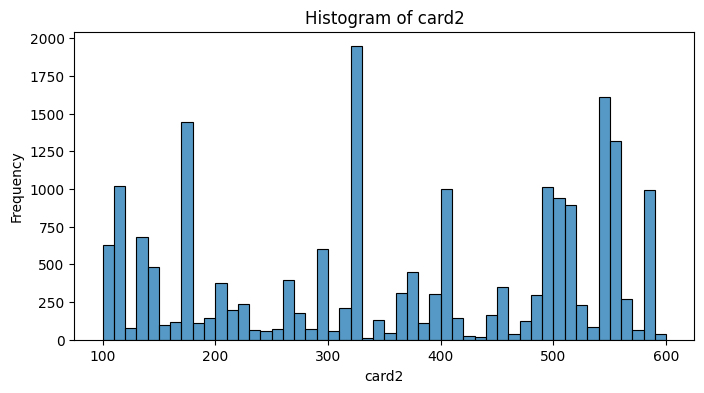

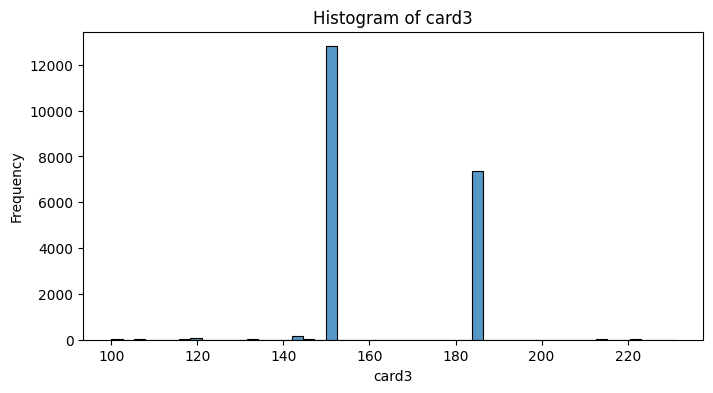

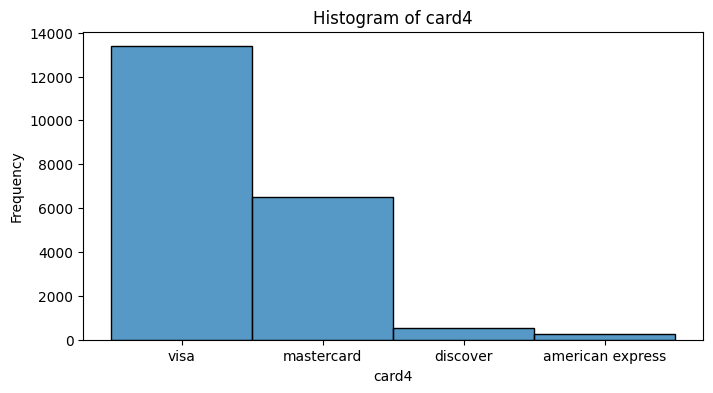

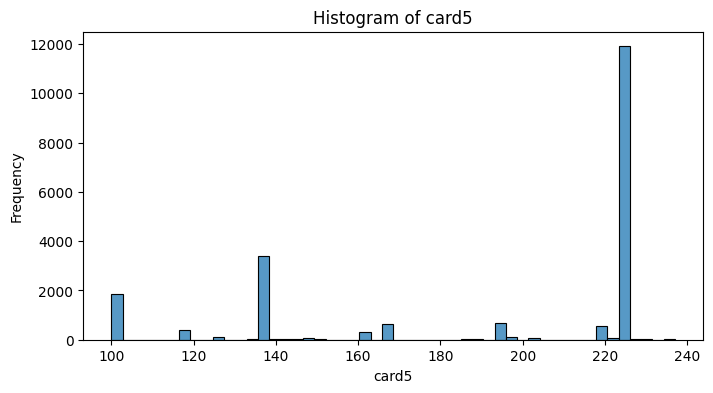

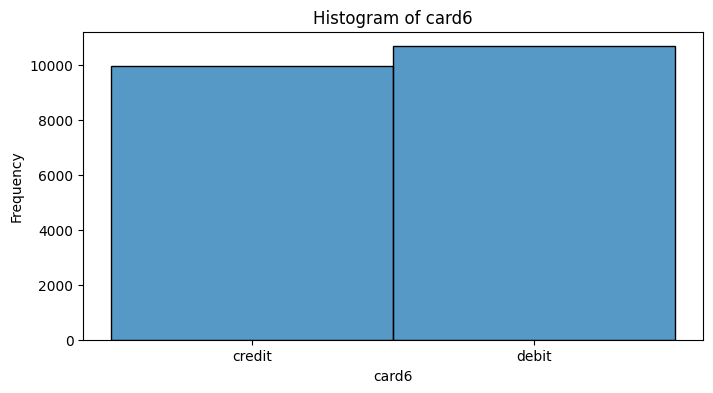

In [98]:
fraudDF = trainDF[trainDF['isFraud'] == 1]
for card in card_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(fraudDF[card].dropna(), kde=False, bins=50)  # Drop NaNs before plotting
    plt.title(f'Histogram of {card}')
    plt.xlabel(f'{card}')
    plt.ylabel('Frequency')
    plt.show()
#Like before Visa and Mastercard hold the highest representation in fraudulent transactions as well. 
#credit and debit hold similar rates of fraud. 

# Distribution of Email Domains (P-Purchaser, R-Receiver) Across All Transactions

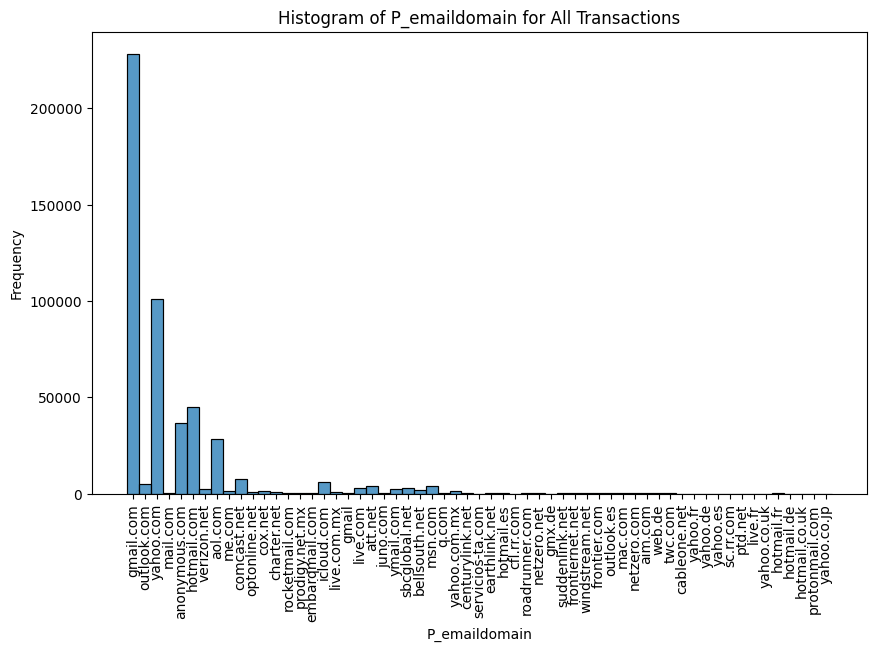

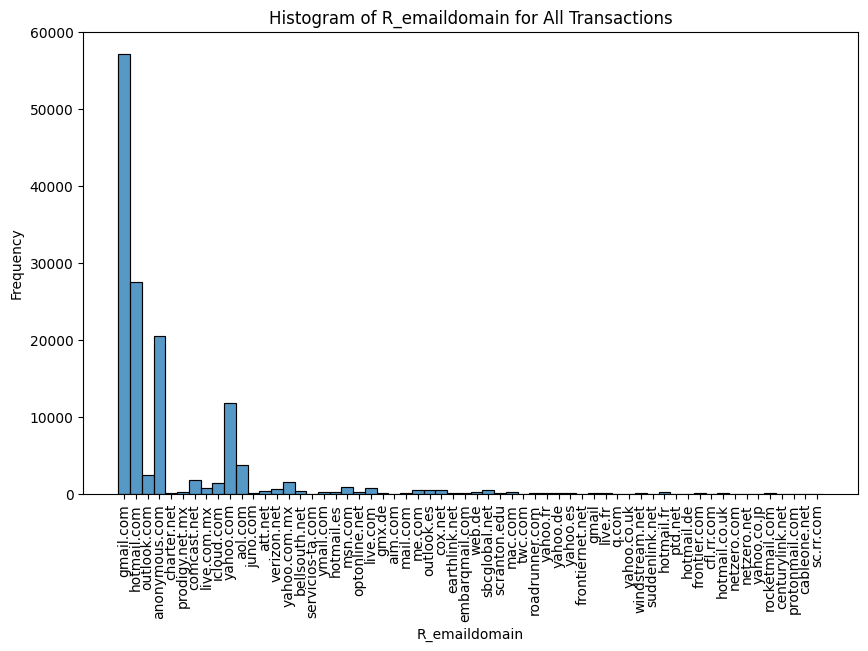

In [99]:
email_columns = ['P_emaildomain', 'R_emaildomain']
for email_col in email_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(trainDF[email_col].dropna(), kde=False)  # Drop NaNs before plotting
    plt.title(f'Histogram of {email_col} for All Transactions')
    plt.xlabel(f'{email_col}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
#We expect the two graphs to look similar as gmail has been dominating the email domain field for years and is used in practice
#by millions of corporations and individuals, whether they are purchasing or selling in a transaction.

# Distribution of Email Domains (P-Purchaser, R-Receiver) Across Fraudulent Transactions

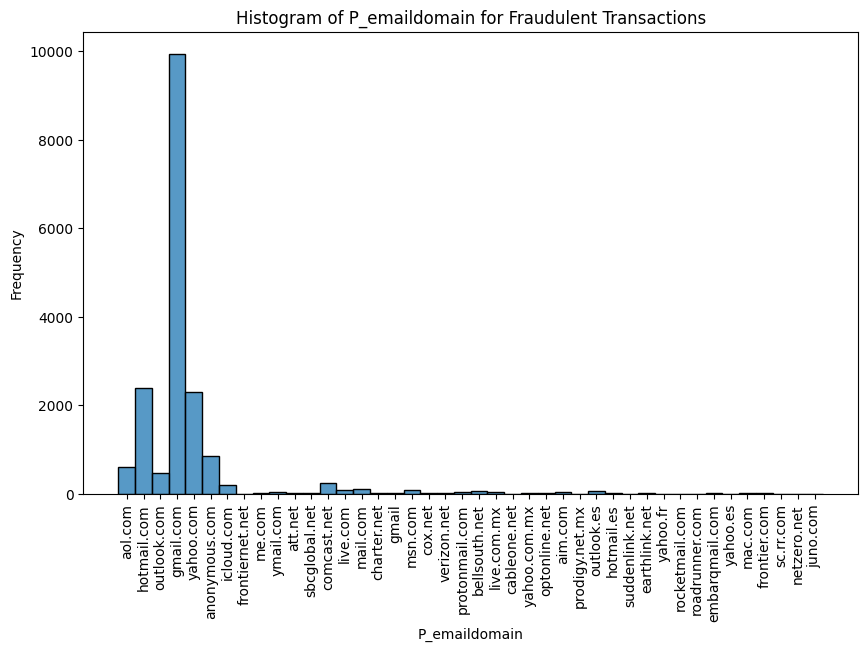

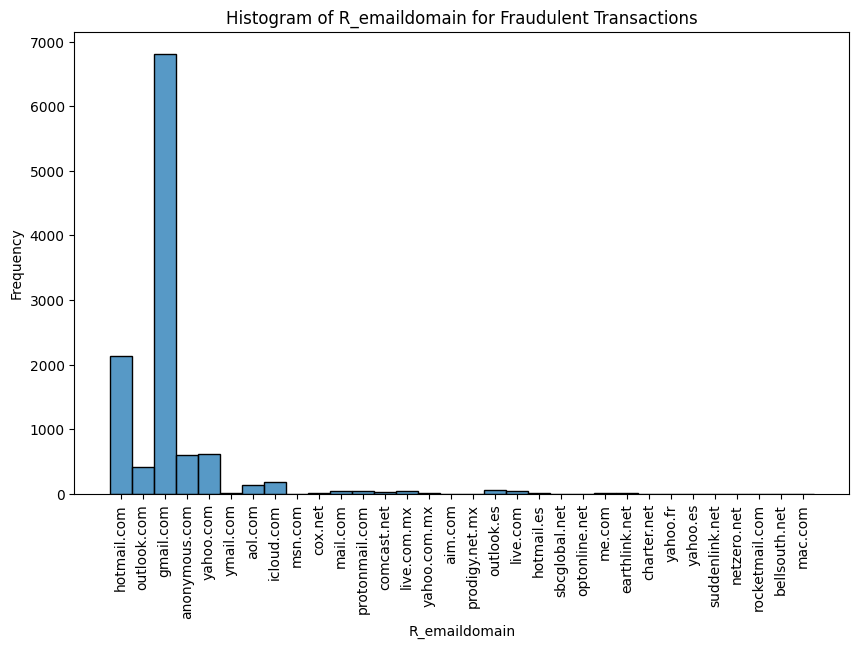

In [100]:
email_columns = ['P_emaildomain', 'R_emaildomain']
for email_col in email_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(fraudDF[email_col].dropna(), kde=False)  # Drop NaNs before plotting
    plt.title(f'Histogram of {email_col} for Fraudulent Transactions')
    plt.xlabel(f'{email_col}')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
#Satisfies hypothesis from last cell, gmail is still #1 regardless of fraudulent or not transaction.

# Address/Distance Feature Analysis 

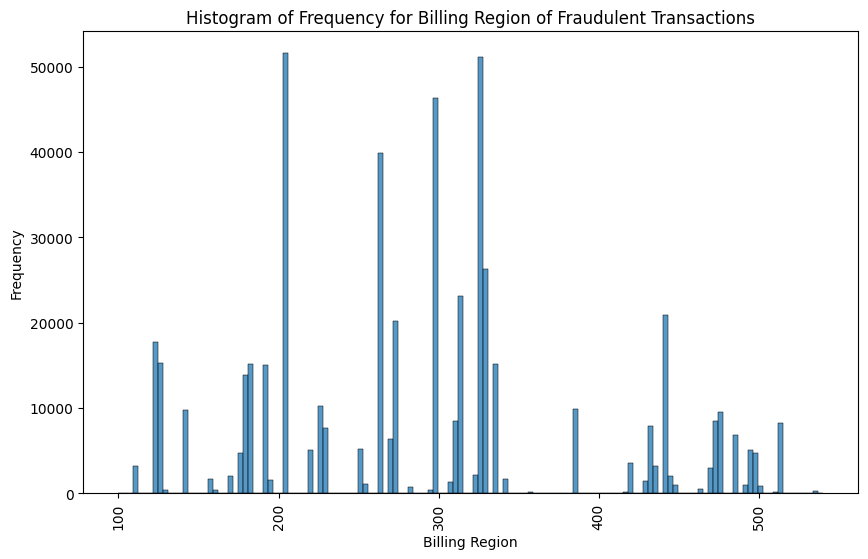

In [101]:
plt.figure(figsize=(10, 6))
sns.histplot(trainDF['addr1'].dropna(), kde=False)  # Drop NaNs before plotting
plt.title(f'Histogram of Frequency for Billing Region of Fraudulent Transactions')
plt.xlabel('Billing Region')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
#We expect fraud to take place all over the country due to the ability to falsify billing addresses. The first graph refers to
#billing region, second refers to which country.

In [102]:
addressIsFraud = trainDF.groupby('addr1').isFraud.mean().sort_values(ascending=False)
print("Percentage Occurences of Which Billing Region Fraud Occurs in:")
addressIsFraud.head(10)

Percentage Occurences of Which Billing Region Fraud Occurs in:


addr1
305.0    0.666667
483.0    0.565217
501.0    0.500000
466.0    0.500000
471.0    0.500000
391.0    0.457143
431.0    0.342105
260.0    0.333333
432.0    0.289474
216.0    0.240741
Name: isFraud, dtype: float64

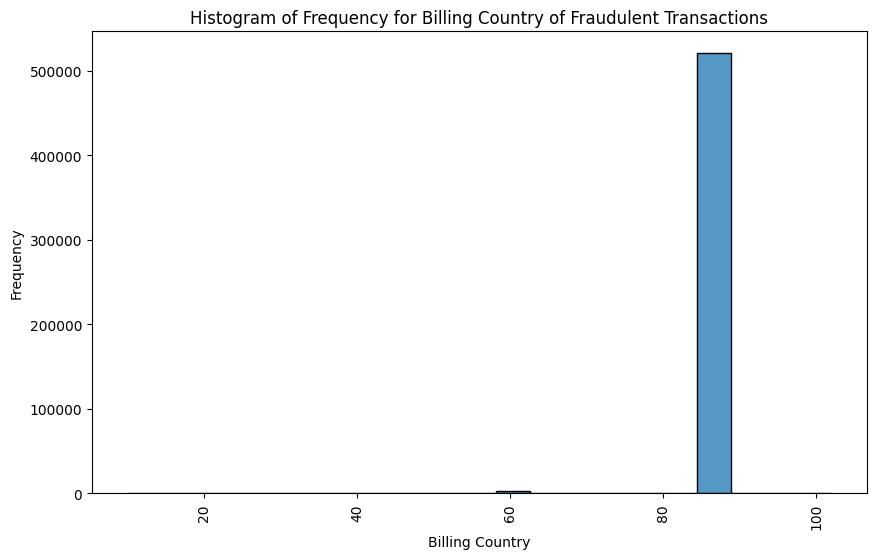

In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(trainDF['addr2'].dropna(), kde=False)  # Drop NaNs before plotting
plt.title(f'Histogram of Frequency for Billing Country of Fraudulent Transactions')
plt.xlabel('Billing Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()
#it can be seen that nearly all transactions from this dataset were taken from one country, it can be assumed to be 
#the US due to usage of Mastercard, Visa, American Express, etc... (Country 87)

# Analyzing Date and Time

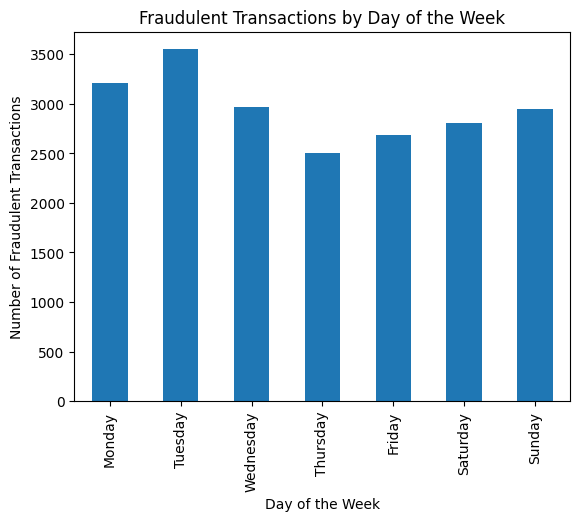

In [104]:
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
fraud_by_day_of_week = fraudDF.groupby('TransactionDayOfWeek').size()
fraud_by_day_of_week.index = fraud_by_day_of_week.index.map(day_mapping)
fraud_by_day_of_week.plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Day of the Week')
plt.show()
#Seems that most fraudulent transactions would take place at the beginning of the week, peaking on Tuesdays.

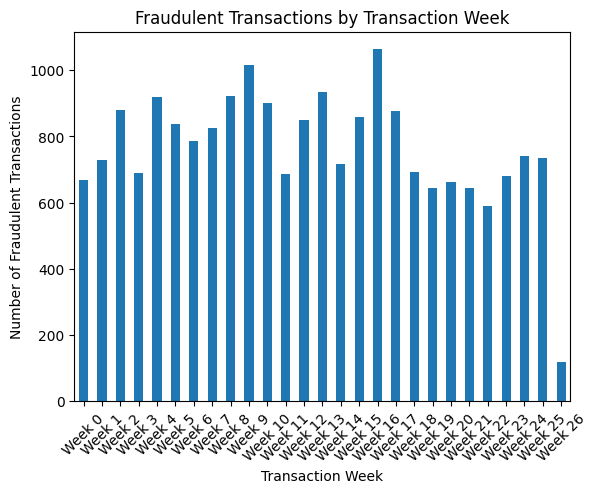

In [105]:
fraud_by_week = fraudDF.groupby('TransactionWeek').size()
fraud_by_week.index = fraud_by_week.index.map(lambda x: f'Week {x}')
fraud_by_week.plot(kind='bar')
plt.xlabel('Transaction Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Transaction Week')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()
#The entirety of this program was 26 weeks it can be seen that the distribution is relatively unfirom with peaks at the 8th and
#16th weeks.

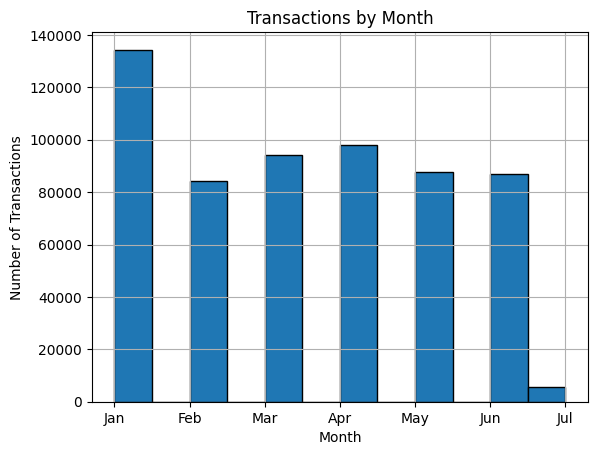

In [106]:
reference_date = pd.Timestamp("2017-01-01")  # Adjust the reference date if needed
trainDF['TransactionDate'] = trainDF['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))

# Extract month from TransactionDate
trainDF['TransactionMonth'] = trainDF['TransactionDate'].dt.month

# Plot a histogram of transactions by month
trainDF['TransactionMonth'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Month')
plt.xticks(range(1, 8), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.show()
#Most transactions take place at the beginning of the year. This makes sense as that time of year is known to contain high
#amounts of spending across the world. 

/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_8940/2145736882.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frauddf['TransactionDate'] = frauddf['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_8940/2145736882.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frauddf['TransactionMonth'] = frauddf['TransactionDate'].dt.month


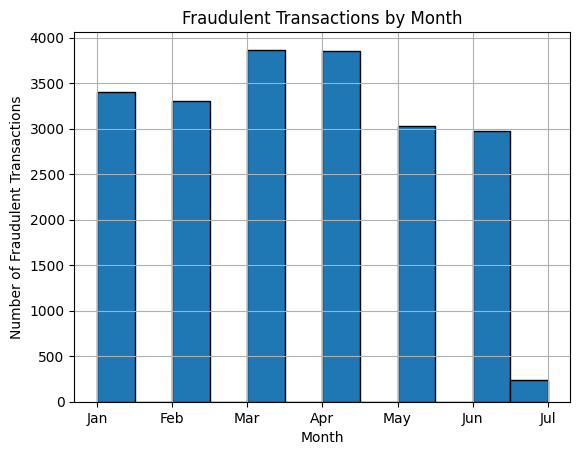

In [107]:
reference_date = pd.Timestamp("2017-01-01")  # Adjust the reference date if needed

# Filter for fraudulent transactions
frauddf = trainDF[trainDF['isFraud'] == 1]

# Convert TransactionDT to datetime format for fraudulent transactions
frauddf['TransactionDate'] = frauddf['TransactionDT'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))

# Extract month from TransactionDate
frauddf['TransactionMonth'] = frauddf['TransactionDate'].dt.month

# Plot a histogram of fraudulent transactions by month
frauddf['TransactionMonth'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions by Month')
plt.xticks(range(1, 8), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul'])
plt.show()
#All fraudulent transactions seem to be equivalently distributed across the year. This invalidates my previous 
#hypothesis as most fraudulent transactions are happening towards the middle of the year, not the beginning.

# Checking Column Null Value Percentages

In [108]:
#showing columns with # entries > 80% being null/empty
trainDF.isnull().mean()[trainDF.isnull().mean() > .8]
#much of dataset is empty

dist2    0.936284
D6       0.876068
D7       0.934099
D8       0.873123
D9       0.873123
           ...   
id_27    0.991247
id_30    0.868654
id_32    0.868619
id_33    0.875895
id_34    0.868248
Length: 74, dtype: float64

# PCA Analysis

In [109]:
#PCA 1D
numeric_cols_train = trainDF.select_dtypes('number')
#separate isFraud into Y component of PCA
x1D = numeric_cols_train.fillna(numeric_cols_train.mean())
x1D.drop(['isFraud'], axis = 1)
y1D = trainDF['isFraud'] #target for later
#scale X component
X1D_scaled = MinMaxScaler().fit_transform(x1D)#scale due to sensitivity of PCA
#start PCA
pca = PCA(n_components = 2)
PCA_component = pca.fit_transform(X1D_scaled)
print(pca.explained_variance_ratio_)
#The first principal component captures approximately 25.5% of the variance in the original data, while the second component captures around 9.9%. 
#This indicates that the two components together explain a significant portion of the variability, with the first component being the most influential.

[0.25054596 0.0987973 ]


Explained variance ratio: [0.25554304 0.10038389]
Total explained variance: 0.35592692909916473


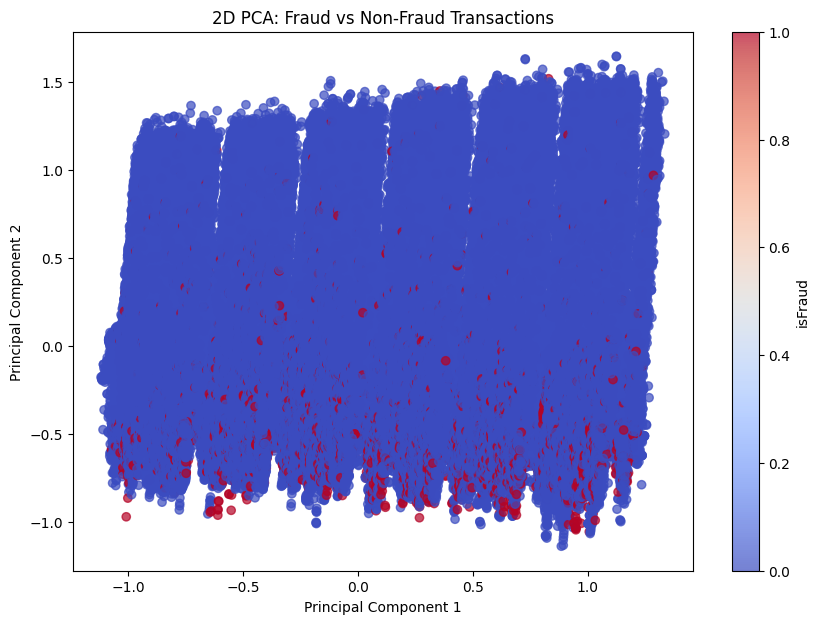

In [110]:
numeric_cols_train = trainDF.select_dtypes('number')
x2D = numeric_cols_train.fillna(numeric_cols_train.mean())
x2D = x2D.drop(['isFraud'], axis=1)  # Drop the 'isFraud' column from X
y2D = trainDF['isFraud']  # Target variable
X2D_scaled = MinMaxScaler().fit_transform(x2D)

pca = PCA(n_components=2)
PCA_components_2D = pca.fit_transform(X2D_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_)}")

plt.figure(figsize=(10, 7))
plt.scatter(PCA_components_2D[:, 0], PCA_components_2D[:, 1], c=y2D, cmap='coolwarm', alpha=0.7)
plt.title('2D PCA: Fraud vs Non-Fraud Transactions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='isFraud')  # Add a color bar to distinguish fraud/non-fraud
plt.show()
#The PCA analysis shows that the first principal component explains 25.55% of the variance, while the second principal component explains 10.04%, resulting in a total explained variance of 35.59%. 
#This indicates that these two components capture a moderate amount of the variation in the data, 
#which may help distinguish between fraud and non-fraud transactions in the visualized 2D space

While PCA is used to reduce the dimensionality of the dataset for visualization purposes, it's clear from the graph that there's no strong separation between fraud and non-fraud transactions using just these two components. Fraudulent transactions appear scattered among the non-fraudulent ones, suggesting that additional features or further dimensionality reduction might be necessary for better classification.

# Isolation Forest Analysis

In [111]:
# Create Isolation Forest and fit it based on the training data.
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=15, verbose=0)
isolationForestTrain = numeric_cols_train.fillna(numeric_cols_train.mean())
forest.fit(isolationForestTrain)
# Generate predictions based on the Isolation Forest
predictions = forest.predict(isolationForestTrain)
print("Normal: ", np.sum(predictions == 1), "Anomalies: ", np.sum(predictions == -1))

Normal:  531486 Anomalies:  59054


# Model Training after Isolation Forest Anomaly Removal 

In [112]:
cleaned_trainDF_Isolation = numeric_cols_train[predictions == 1]
X_cleaned_Isolation = cleaned_trainDF_Isolation.drop(columns=['isFraud'])  # Features
y_cleaned_Isolation = trainDF.loc[cleaned_trainDF_Isolation.index, 'isFraud']  # Target
X_train_isolation, X_test_isolation, y_train_isolation, y_test_isolation = train_test_split(X_cleaned_Isolation, y_cleaned_Isolation, test_size=0.3, random_state=0, stratify=y_cleaned_Isolation)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
model.fit(X_train_isolation, y_train_isolation)
y_pred_isolation = model.predict(X_test_isolation)
print("Accuracy:", accuracy_score(y_test_isolation, y_pred_isolation))
print("Classification Report:\n", classification_report(y_test_isolation, y_pred_isolation))

Accuracy: 0.9789897520163566
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    155971
           1       0.97      0.04      0.07      3475

    accuracy                           0.98    159446
   macro avg       0.97      0.52      0.53    159446
weighted avg       0.98      0.98      0.97    159446



# Mahalanobis Outlier Detection

In [113]:
numeric_cols_train = trainDF.select_dtypes('number')
numeric_cols_train = numeric_cols_train.fillna(numeric_cols_train.mean())
cov_matrix = np.cov(numeric_cols_train.values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_values = numeric_cols_train.mean(axis=0).values
mahalanobis_distances = numeric_cols_train.apply(lambda row: mahalanobis(row, mean_values, inv_cov_matrix), axis=1)
numeric_cols_train['Mahalanobis_Distance'] = mahalanobis_distances
threshold = np.percentile(mahalanobis_distances, 97.5)
numeric_cols_train['Is_Outlier'] = numeric_cols_train['Mahalanobis_Distance'] > threshold
outliers = numeric_cols_train[numeric_cols_train['Is_Outlier'] == True]
outlier_count = numeric_cols_train['Is_Outlier'].sum()

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1035: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_8940/212830275.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  numeric_cols_train['Mahalanobis_Distance'] = mahalanobis_distances
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_8940/212830275.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  numeric_cols_train['Is_Outlier'] = numeric_cols_tr

# Model Training after Mahalnobis Outlier Removal

In [114]:
cleaned_trainDF = numeric_cols_train[numeric_cols_train['Is_Outlier'] == False]
cleaned_trainDF = cleaned_trainDF.drop(columns=['Mahalanobis_Distance', 'Is_Outlier'])
X = cleaned_trainDF.drop(columns=['isFraud'])  # Features
y = trainDF.loc[cleaned_trainDF.index, 'isFraud']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)  # You can adjust n_estimators as needed
model.fit(X_train, y_train) 

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)

In [115]:
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[170843    120]
 [  4547   1652]]
Accuracy: 0.9737


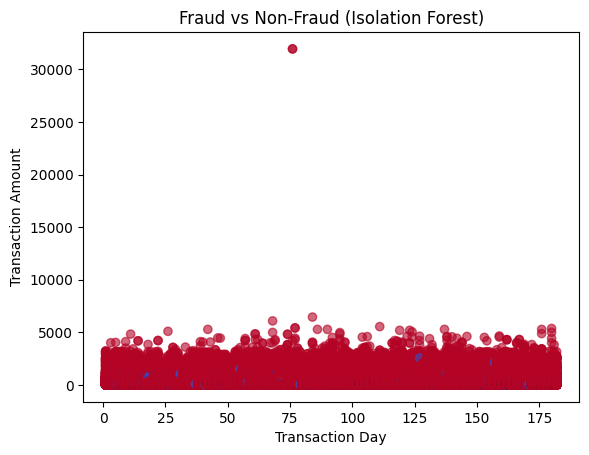

In [116]:
iso_forest = IsolationForest(contamination=0.02, random_state=0)  # Adjust contamination level as needed
fraud_predictions = iso_forest.fit_predict(X)
plt.scatter(X['TransactionDay'], X['TransactionAmt'], c=fraud_predictions, cmap='coolwarm', alpha=0.6)
plt.xlabel('Transaction Day')
plt.ylabel('Transaction Amount')
plt.title('Fraud vs Non-Fraud (Isolation Forest)')
plt.show()

# SMOTE Balancing

In [117]:
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0, stratify=y_resampled)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[165453   5511]
 [ 10323 160640]]
Accuracy: 0.9537


# Machine Learning Morphism (Standard Scaler -> PCA -> RF -> Loss Function)

In [118]:
#Standard Scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols_train.fillna(numeric_cols_train.mean()))

#pca
pca = PCA(n_components=2)
pca_transformed_data = pca.fit_transform(scaled_data)

#rf
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
model.fit(X_train, y_train) #uses X_train and y_train from Mahalanobis Outlier Removed Dataset
y_pred = model.predict(X_test)

#loss
loss_value = log_loss(y_test, y_pred)

In [119]:
print("Loss Value: ", loss_value)

Loss Value:  1.6691141903484694


# Misclassification Errors (Type 1 and Type 2):

In [120]:
XMissclassification = numeric_cols_train.drop(columns=['isFraud'])
yMissclassification = numeric_cols_train['isFraud']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(XMissclassification, yMissclassification, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_m)
X_test_scaled = scaler.transform(X_test_m)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train_m)
y_pred = rf_model.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test_m, y_pred)
print("Confusion Matrix:\n", conf_matrix)

tn, fp, fn, tp = conf_matrix.ravel()
type_1_error_rate = fp / (fp + tn)  # False Positive Rate
type_2_error_rate = fn / (fn + tp)  # False Negative Rate

print(f"Type 1 Error Rate (False Positive Rate): {type_1_error_rate}")
print(f"Type 2 Error Rate (False Negative Rate): {type_2_error_rate}")

print(classification_report(y_test_m, y_pred))

Confusion Matrix:
 [[170650    171]
 [  3326   3015]]
Type 1 Error Rate (False Positive Rate): 0.0010010478805299115
Type 2 Error Rate (False Negative Rate): 0.5245229459075855
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    170821
           1       0.95      0.48      0.63      6341

    accuracy                           0.98    177162
   macro avg       0.96      0.74      0.81    177162
weighted avg       0.98      0.98      0.98    177162



In [121]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train_m)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Confusion Matrix and classification metrics
print(confusion_matrix(y_test_m, y_pred_xgb))
print(classification_report(y_test_m, y_pred_xgb))

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:40:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[170520    301]
 [  3122   3219]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    170821
           1       0.91      0.51      0.65      6341

    accuracy                           0.98    177162
   macro avg       0.95      0.75      0.82    177162
weighted avg       0.98      0.98      0.98    177162



# Feature Engineering

In [122]:
trainDF = trainDF.sort_values(by=['TransactionID', 'TransactionDT'])
trainDF['TransactionDensity'] = trainDF['TransactionAmt'] / trainDF['TransactionWeek']
trainDF['Amt_Day_Interaction'] = trainDF['TransactionAmt'] * trainDF['TransactionDay']
if 'DeviceInfo' in trainDF.columns:
    trainDF['Amt_Device_Interaction'] = trainDF['TransactionAmt'] * trainDF['DeviceInfo'].apply(lambda x: hash(x) % 10)

trainDF['TransactionAmt_Binned'] = pd.cut(trainDF['TransactionAmt'], bins=[-1, 50, 100, 200, 500, 1000, np.inf], labels=[1, 2, 3, 4, 5, 6])

trainDF['Amt_To_DayOfWeek_Ratio'] = trainDF['TransactionAmt'] / (trainDF['TransactionDayOfWeek'] + 1)
trainDF['Amt_To_Week_Ratio'] = trainDF['TransactionAmt'] / (trainDF['TransactionWeek'] + 1)

trainDF['Time_Diff'] = trainDF.groupby('card1')['TransactionDT'].diff()
trainDF['Time_Diff'].fillna(-1, inplace=True)

card_agg = trainDF.groupby('card1')['TransactionAmt'].agg(['mean', 'std', 'count']).reset_index()
card_agg.columns = ['card1', 'Card_Transaction_Mean', 'Card_Transaction_Std', 'Card_Transaction_Count']
trainDF = pd.merge(trainDF, card_agg, on='card1', how='left')

fraud_prob = trainDF.groupby('card1')['isFraud'].mean().to_dict()
trainDF['Fraud_Prob'] = trainDF['card1'].map(fraud_prob)

card4_frequency = trainDF['card4'].value_counts().to_dict()
trainDF['card4_freq'] = trainDF['card4'].map(card4_frequency)

/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_8940/2307240399.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trainDF['Time_Diff'].fillna(-1, inplace=True)


In [123]:
trainDF.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,Amt_Device_Interaction,TransactionAmt_Binned,Amt_To_DayOfWeek_Ratio,Amt_To_Week_Ratio,Time_Diff,Card_Transaction_Mean,Card_Transaction_Std,Card_Transaction_Count,Fraud_Prob,card4_freq
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,2,34.25,68.5,-1.0,351.931163,371.141254,43,0.232558,6651.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,1,14.50,29.0,-1.0,234.292753,460.356975,683,0.046852,189217.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,2,29.50,59.0,-1.0,97.015542,100.128858,1108,0.008123,384767.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.0,1,25.00,50.0,-1.0,123.416340,192.717425,4209,0.014018,189217.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,200.0,1,25.00,50.0,-1.0,96.972222,56.629451,18,0.055556,189217.0


# Time + Location

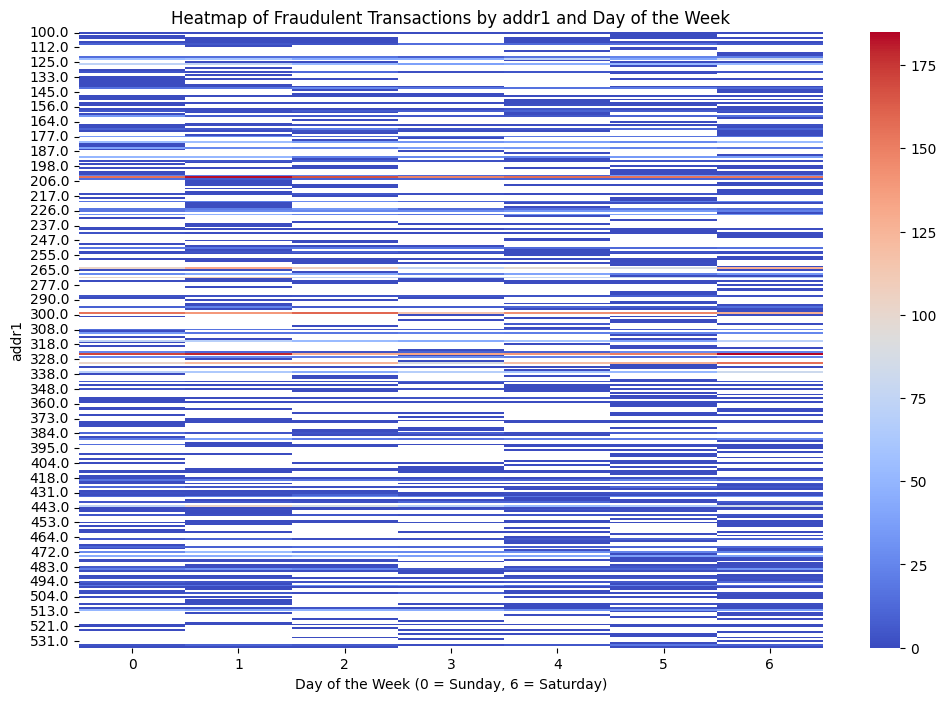

In [129]:
np.random.seed(42)
addr1_fraud_pivot = pd.pivot_table(trainDF, values='isFraud', index='addr1', columns='TransactionDayOfWeek', aggfunc='sum')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(addr1_fraud_pivot, cmap='coolwarm', annot=False, cbar=True)
plt.title('Heatmap of Fraudulent Transactions by addr1 and Day of the Week')
plt.xlabel('Day of the Week (0 = Sunday, 6 = Saturday)')
plt.ylabel('addr1')
plt.show()

## Feature Engineering Visualizations

# For All Transactions

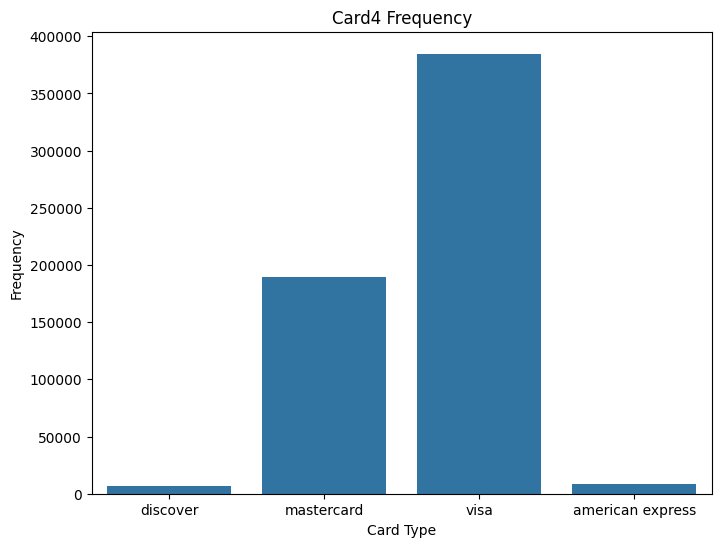

In [124]:
plt.figure(figsize=(8, 6))
sns.barplot(x='card4', y='card4_freq', data=trainDF)
plt.title("Card4 Frequency")
plt.ylabel('Frequency')
plt.xlabel('Card Type')
plt.show()

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


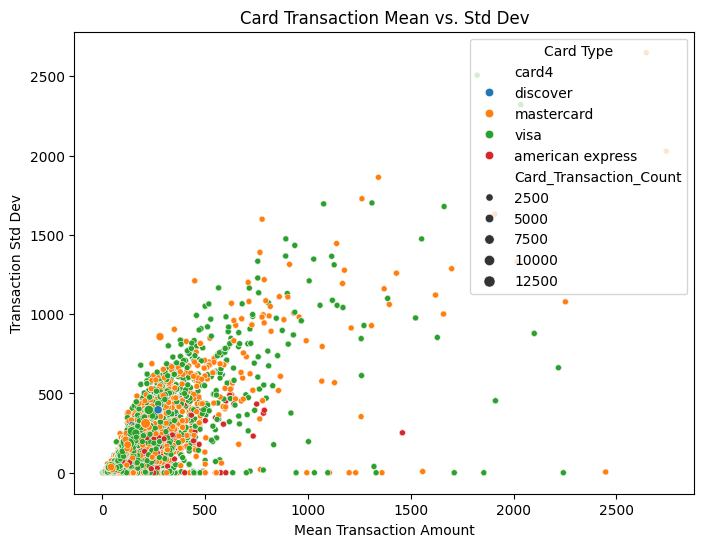

In [125]:
# 2. Visualizing aggregated features for card1 (mean and standard deviation of transaction amount)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Card_Transaction_Mean', y='Card_Transaction_Std', size='Card_Transaction_Count', hue='card4', data=trainDF)
plt.title("Card Transaction Mean vs. Std Dev")
plt.xlabel('Mean Transaction Amount')
plt.ylabel('Transaction Std Dev')
plt.legend(title='Card Type')
plt.show()

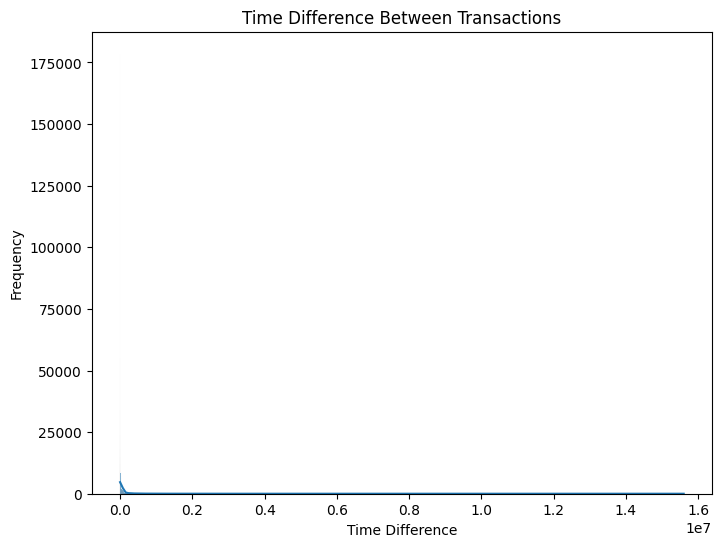

In [126]:
# 3. Visualizing Time_Diff feature (time difference between transactions)
plt.figure(figsize=(8, 6))
sns.histplot(trainDF['Time_Diff'], kde=True)
plt.title("Time Difference Between Transactions")
plt.xlabel('Time Difference')
plt.ylabel('Frequency')
plt.show()

# For Fraudulent Transactions

In [127]:
trainDF.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,Amt_Device_Interaction,TransactionAmt_Binned,Amt_To_DayOfWeek_Ratio,Amt_To_Week_Ratio,Time_Diff,Card_Transaction_Mean,Card_Transaction_Std,Card_Transaction_Count,Fraud_Prob,card4_freq
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,2,34.25,68.5,-1.0,351.931163,371.141254,43,0.232558,6651.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,1,14.50,29.0,-1.0,234.292753,460.356975,683,0.046852,189217.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,2,29.50,59.0,-1.0,97.015542,100.128858,1108,0.008123,384767.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.0,1,25.00,50.0,-1.0,123.416340,192.717425,4209,0.014018,189217.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,200.0,1,25.00,50.0,-1.0,96.972222,56.629451,18,0.055556,189217.0


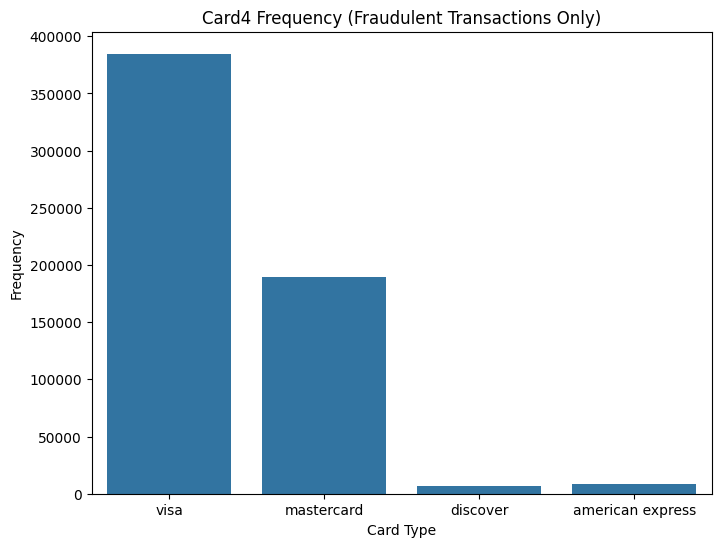

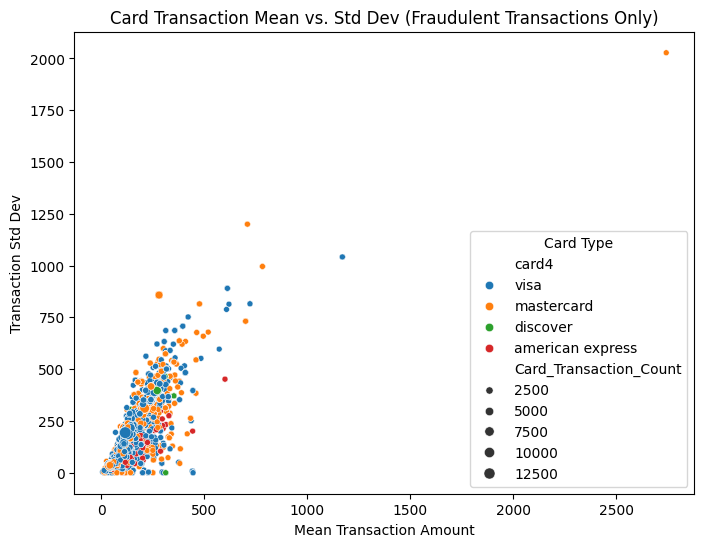

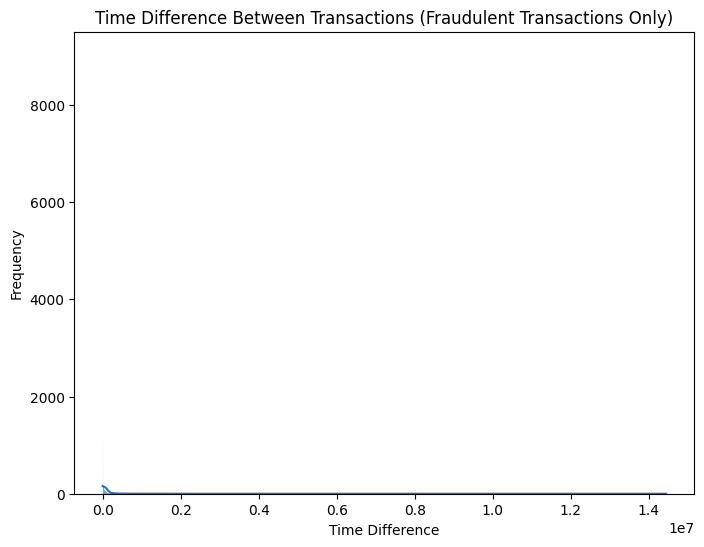

In [128]:
fraudDF = trainDF[trainDF['isFraud'] == 1]

plt.figure(figsize=(8, 6))
sns.barplot(x='card4', y='card4_freq', data=fraudDF)
plt.title("Card4 Frequency (Fraudulent Transactions Only)")
plt.ylabel('Frequency')
plt.xlabel('Card Type')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='Card_Transaction_Mean', y='Card_Transaction_Std', size='Card_Transaction_Count', hue='card4', data=fraudDF)
plt.title("Card Transaction Mean vs. Std Dev (Fraudulent Transactions Only)")
plt.xlabel('Mean Transaction Amount')
plt.ylabel('Transaction Std Dev')
plt.legend(title='Card Type')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(fraudDF['Time_Diff'], kde=True)
plt.title("Time Difference Between Transactions (Fraudulent Transactions Only)")
plt.xlabel('Time Difference')
plt.ylabel('Frequency')
plt.show()